In [1]:
import time
import random
import numpy as np
from collections import defaultdict
from optparse import OptionParser
import pickle
import scipy.misc as smi
from PIL import Image
import sys

# Required libraries
import h5py
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization as BN

import matplotlib.pylab as plt
from IPython.display import Image, display
%matplotlib inline

import sys
sys.path.append('../')
# d-script imports
import data_iters
from data_iters.hdf5_iterator import Hdf5MiniBatcher
from data_iters.archive.iam_iterator import IAM_MiniBatcher
from data_iters.minibatcher import MiniBatcher
from viz_tools.array_to_png import get_png_from_array, display_img_array
from demo_pipeline.fielutil import *
from denoiser.noisenet import conv4p_model, conv3p_model, conv2p_model, conv2_model

from fielutil import *

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, CuDNN 4004)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
print "Loading original weights into GPU memory"
model=conv4p_model(shingle_dim=(56,56))
model.load_weights('/work/models/conv4p_linet56-iambin-tifs.hdf5')
print "Finished weight load"
input_shape = model.input_shape
output_shape = model.output_shape[1]

Loading original weights into GPU memory
Compiling model
Finished compilation
Finished weight load


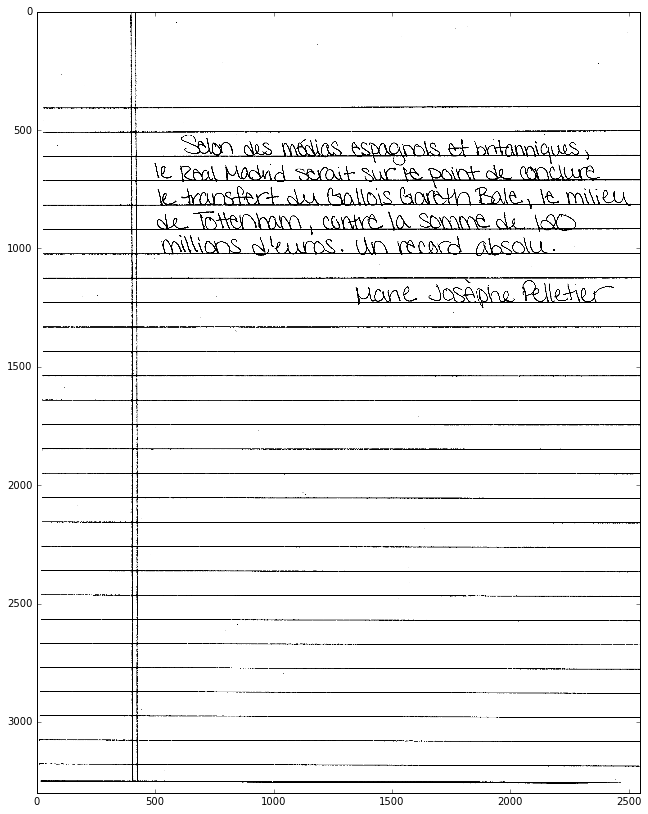

In [30]:
hdf5ims = h5py.File('/fileserver/nmec-handwriting/flat_nmec_bin_uint8.hdf5')
im = hdf5ims['FR-007-007.bin.tif'].value
plt.figure(figsize=(14,14))
plt.imshow(im,cmap='gray')

In [37]:
print "Begin data transfer to buffers on image "
input_buffer = []
for i in xrange(0, im.shape[0] - input_shape[2] + 1, input_shape[2]):
    for j in xrange(0, im.shape[1] - input_shape[3] + 1, input_shape[3]):
        input_buffer += [im[i:i+input_shape[2], j:j+input_shape[3]]]
predictbuffer = np.expand_dims(1.0-np.array(input_buffer)/255.0, 1)
output_buffer = model.predict(predictbuffer, verbose = 1)

Begin data transfer to buffers on image 
2610/2610 [==============================] - 0s     


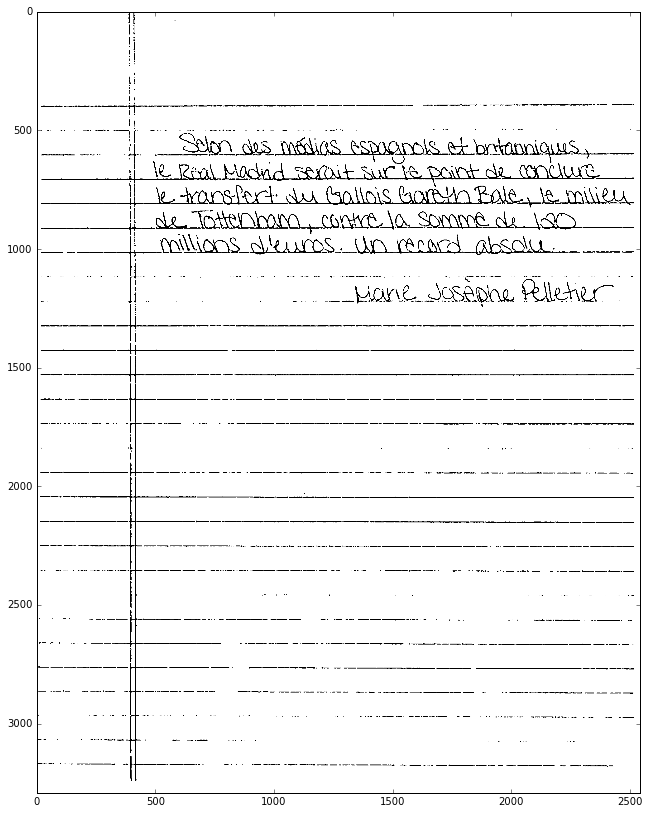

In [38]:
output_im = np.zeros(im.shape)
shapesize = (input_shape[2], input_shape[3])
k = 0
for i in xrange(0, im.shape[0] - input_shape[2] + 1, input_shape[2]):
    for j in xrange(0, im.shape[1] - input_shape[3] + 1, input_shape[3]):
        output_im[i:i+input_shape[2],j:j+input_shape[3]] = output_buffer[k].reshape(shapesize)
        k+=1
        
output_im = output_im > 0.5
plt.figure(figsize=(14,14))
plt.imshow(1-output_im, cmap='gray')

In [36]:
model.load_weights('/work/models/conv4p_linet56-iambin-tifs.hdf5')
im = 255*(1-output_im[4:,4:])